# Geographic feature engineering

In machine learning and data science, we are often equipped with *tons* of data. Indeed, given the constellation of packages to query data services, free and open source data sets, and the rapid and persistent collection of geographical data, there is simply too much data to even represent coherently in a single, tidy fashion. However, we often need to be able to construct useful *features* from this rich and deep sea of data. 

Where data is available, but not yet directly *usable*, we must use *feature engineering* to construct useful data for modelling a given phenomenon of interest. Often, feature engineering involves applying additional *domain knowledge* to raw information in order to structure it in a manner that is meaningful for a model. Often, this involves some sort of *transformation* of the original dataset, which is a well-studied concept in both classical statistics and remains so in machine learning methods. While *feature engineering* always relies on this implicit domain knowledge, it is an extremely important part of adapting general-purpose algorithms to unique or distinctive problems facing the every-day data scientist. 

Geography is one of the most high-quality, ubiquitous ways to introduce *domain knowledge* into a problem: everything has a position in both *space* and *time*. And, while things that happen near to one another *in time* do not necessarily have a fundamental relationship, things that are *near* one another are often related. Thus, space is the ultimate *linkage key*, allowing us to connect different datasets together in order to improve our models and our predictions. This means that, even for *aspatial*, "non-geographic" data, you can use *spatial feature engineering* to create useful, highly-relevant features for your analysis. 

At its core, *spatial feature engineering* is the process of developing additional information from raw data using *geographic knowledge*. This synthesis could occur *between* datasets, where geography is used to link samples in separate datasets together; or *within* datasets, where geography can be used to borrow information from nearby samples. Building linkages *between* datasets is often called "Map Matching", while we use the term "Map Synthesis" to describe the use of geographical structure to derive new features from existing data. Both kinds of geographic feature engineering will be covered in this chapter, starting first with various methods for Map Matching when modelling Airbnb nightly rental prices in San Diego.

In [1]:
import geopandas, pandas, libpysal.weights as weights, contextily
import matplotlib.pyplot as plt
import cenpy
import numpy
import osmnx
import rasterio
from rasterio.plot import show as rioshow

Throughout this chapter, we will use a common dataset to which we want to append more information through geography. For the illustration, we will use the set of [AirBnb properties](../data/airbnb/regression_cleaning). Let's read it:

In [2]:
airbnbs = geopandas.read_file('../data/airbnb/regression_db.geojson')

## Feature Engineering Using Map Matching
*Using spatial relationships between two datasets to transfer information from one to another for a model.*
"Space is the ultimate linkage key." - DAB


### Counting *nearby* features

A first, conceptually straightforward, approach is to augment our dataset by counting how many points of a different dataset are in the vicinity of each observation. For example, we might want to know how many bars and restaurants each AirBnb has within a given radious. This count can then become an additional  feature of our dataset, stored in a new column of `airbnbs`.

To obtain information on the location of restaurants and bars, we can download it from OpenStreetMap directly using `osmnx`. We first query all the points of interest (POIs) within the area our points cover, and then filter out everything except restaurants and bars. For that, we require to get a polygon that covers all our `airbnbs` points. From Chapter 8, we can recall that there are a few different hulls that can be used. We'll use the Convex Hull here, which is the smallest convex polygon that covers all of the points in the set. 

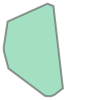

In [3]:
airbnbs_ch = airbnbs.unary_union.convex_hull
airbnbs_ch

Using this polygon, we can use the `osmnx` package to fetch points of interest (POIs) from OpenStreetMap. We can make our request more manageable by only requesting points of interest that fall within specific categories. Below, we'll request POIs within San Diego that are "restaurants" or "bars," according to their metadata stored in OpenStreetMap. (*note: this step requires internet connection as it is querying a remote server*):

In [4]:
%%time
pois = osmnx.pois_from_polygon(airbnbs_ch,
                               tags={"amenity": ['restaurant', 'bar']}
                              )

CPU times: user 1.2 s, sys: 27.7 ms, total: 1.23 s
Wall time: 3.68 s


This provides us with every location within our convex hull that is tagged as a "restaurant" or "bar" its metadata on OpenStreteMap. Overall, this provides us with about 1300 points of interest: 

In [5]:
pois.groupby('amenity').amenity.count()

amenity
bar            304
restaurant    1005
Name: amenity, dtype: int64

Once loaded into `pois` as a `GeoDataFrame`, let's take a peek at their location, as compared with AirBnb spots:

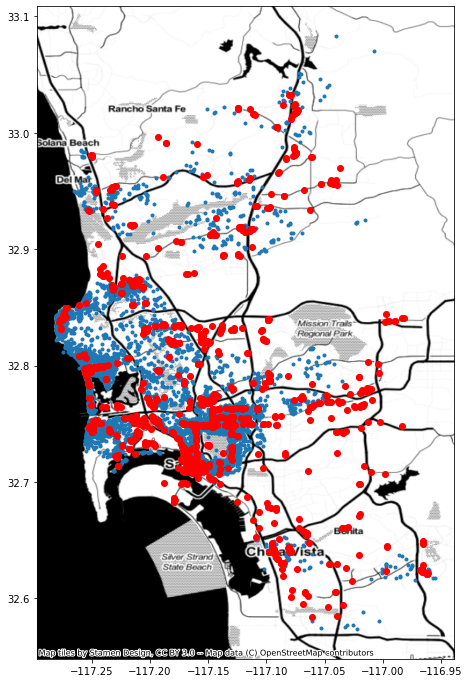

In [6]:
f,ax = plt.subplots(1,figsize=(12, 12))
airbnbs.plot(ax=ax, marker='.')
pois.plot(ax=ax, color='r')
contextily.add_basemap(ax, 
                       crs=airbnbs.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

Now, for some feature engineering, it may be extremely useful to know whether an Airbnb is located in a "hot" location, with a lot of restaurants and bars to choose from. Alternatively, if Airbnbs are very remote, they might not be as lucrative for short, expensive "city-break" reservations. That is, Airbnb users may decide to reserve stays where there are a lot of dining and drinking opportunities, and thus may be *willing to pay more* for the same accommodation. We might be able to predict prices better if we know about the drinking and dining scene near the Airbnb. 

Thus, we can *engineer features* in the Airbnb data using the nearby POIs. To do this, we can create a new feature for the AirBnb dataset --that is, a new column in `airbnbs`-- which incorporates information about how many POIs are *nearby* each property. This kind of "feature counting" is useful in applications where the mere presence of nearby features can affect the quantity we are modelling. 

To do this kind of feature engineering, let us first walk through what we need to do at a conceptual level: 

1. Decide what is *nearby*. This will dictate how far we go from each AirBnb when counting the number of "nearby" bars & restaurants. For this example, we will use 500 meter buffer, which is approximately the distance of a leisurely ten-minute walk.
2. For each AirBnb, determine whether POIs are *within* a leisurely 10-minute walk. 
3. Count how many POIs are withing the specified radius of each AirBnb.

At the end of this procedure, we have the number of bars & restuarants that are within a leisurely walk of the AirBnb, which might be useful in predicting the price of each AirBnb. 

With this, let us now translate the list above into code. For part 1., we need to be able to measure distances in metres. However, `airbnbs` is originally expressed in degrees, since it is provided in terms of locations in latitude and longitude:

In [7]:
airbnbs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In addition, the `pois` are also provided in terms of their latitude & longitude:

In [8]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Therefore, we need to convert this into a coordinate system that is easier to work with. Here, we will use a projection common for mapping in California, the California Albers projection:

In [9]:
airbnbs_albers = airbnbs.to_crs(epsg=3311)
pois_albers = pois.to_crs(epsg=3311)

In [10]:
pois_albers.crs

<Projected CRS: EPSG:3311>
Name: NAD83(HARN) / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA - California
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

With this, we can create the radius of 500m around each AirBnb. This is often called *buffering*, where a shape is dilated by a given radius.

In [11]:
airbnbs_albers['buffer_500m'] = airbnbs_albers.buffer(500)

Now, `abb_buffer` contains a 500-meter circle around each Airbnb.

Using these, we can count the number of POIs that are within these areas using a *spatial join*. Spatial joins link geometries based on spatial relationships (or predicates). Here, we need to know the relationship: `pois within airbnb_buffers`, where `within` is the predicate relating `pois` to `airbnb_buffers`. Predicates are not always *reversible*: no `airbnb_buffer` can be `within` a `poi`. In `geopandas`, we can compute all pairs of relations between the `pois` and `airbnb_buffers` efficiently using the `sjoin` function, which takes a `predicate` argument defining the requested relationship between the first & second argument. 

In [12]:
joined = geopandas.sjoin(pois_albers,
                    airbnbs_albers.set_geometry('buffer_500m')[['id', 'buffer_500m']],
                    op="within"
                   )

The resulting joined object `joined` contains a row for every pair of POI and AirBnb that are linked. From there, we can apply a group-by operation, using the AirBnb ID, and count how many POIs each AirBnb has within 500m of distance:

In [13]:
poi_count = joined.groupby("id")\
                  ["osmid"]\
                  .count()\
                  .to_frame('poi_count')
poi_count.head()

,poi_count
id,
6,12
5570,7
9553,12
38245,1
69385,8


The resulting `Series` is indexed on the AirBnb IDs, so we can assign it to the original `airbnbs` table. In this case, we know by construction that missing AirBnbs in `poi_count` do not have any POI within 500m, so we can fill missing values in the column with zeros.

In [14]:
airbnbs_w_counts = airbnbs_albers.merge(poi_count, left_on='id', right_index=True)\
                                 .fillna({"poi_count": 0})

We can visualise now the distribution of counts to get a sense of how "well-served" AirBnb properties are arranged over space (for good measure, we'll also add a legendgram):

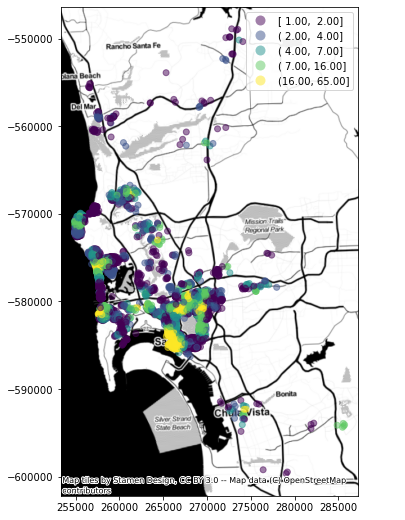

In [15]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      alpha=0.5,
                      legend=True,
                      ax=ax
                     )
contextily.add_basemap(ax, 
                       crs=airbnbs_albers.crs.to_string(), 
                       source=contextily.providers.Stamen.Toner
                      )

---

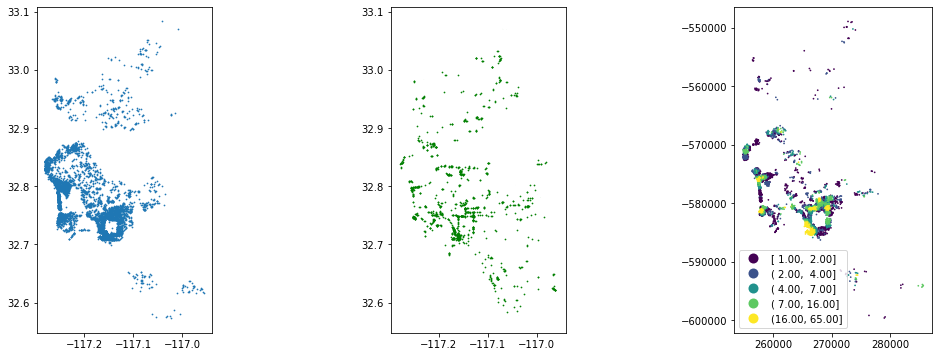

In [16]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

airbnbs.plot(ax=axs[0], markersize=0.5)

pois.plot(ax=axs[1], color="green", markersize=0.5)

airbnbs_w_counts.plot(column="poi_count",
                      scheme="quantiles",
                      markersize=0.5,
                      legend=True,
                      ax=axs[2]
                     )

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

plt.show()

### Assigning point values from surfaces: elevation of AirBnbs

We have just seen how to count points around each observation in a point dataset. In other cases, we might be confronted with a related but different challenge: transfering the value of a particular point in a surface to a point in a different dataset. 

To make this more accessible, let us illustrate the context with an example question: *what is the elevation of each AirBnb property?* To answer it, we require, at least, the following:

1. A sample of AirBnb property locations.
1. A dataset of elevation. We will use here the [NASA DEM](../data/nasadem/README.md) surface for the San Diego area.

Let us bring the elevation surface:

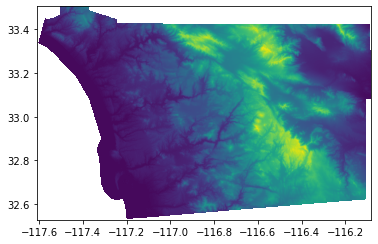

<AxesSubplot:>

In [17]:
dem = rasterio.open("../data/nasadem/nasadem_sd.tif")
rioshow(dem)

Let's first check the CRS is aligned with our sample of point locations:

In [18]:
dem.crs

CRS.from_epsg(4326)

We have opened the file with `rasterio`, which has not read the entire dataset just yet. This feature allows us to use this approach with files that are potentially very large, as only requested data is read into memory.

To extract a discrete set of values from the elevation surface in `dem`, we can use `sample`. For a single location, this is how it works:

In [19]:
list(dem.sample([(-117.24592208862305, 32.761619109301606)]))

[array([7], dtype=int16)]

Now, we can take this logic and apply it to a sequence of coordinates. For that, we need to extract them from the `geometry` object:

In [20]:
abb_xys = pandas.DataFrame({"X": airbnbs.geometry.x, 
                            "Y": airbnbs.geometry.y
                           }).to_records(index=False)

In [21]:
elevation = pandas.DataFrame(dem.sample(abb_xys),
                             columns=["Elevation"],
                             index=airbnbs.index
                            )
elevation.head()

,Elevation
0,112
1,3
2,99
3,114
4,30


Now we have a table with the elevation of each  AirBnb property, we can plot it on a map for visual inspection:

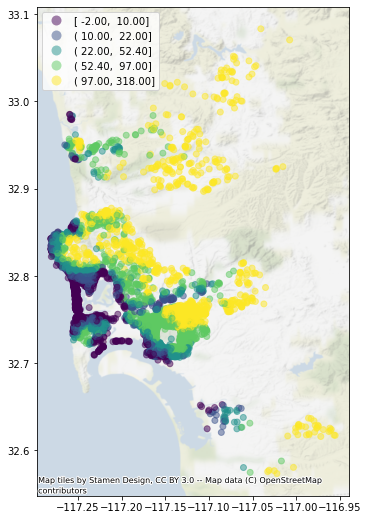

In [22]:
f, ax = plt.subplots(1, figsize=(9, 9))
airbnbs.join(elevation)\
       .plot(column="Elevation",
             scheme="quantiles",
             legend=True,
             alpha=0.5,
             ax=ax
            )
contextily.add_basemap(ax, 
                       crs=airbnbs.crs.to_string(), 
                       source=contextily.providers.Stamen.TerrainBackground,
                       alpha=0.5
                      )

---

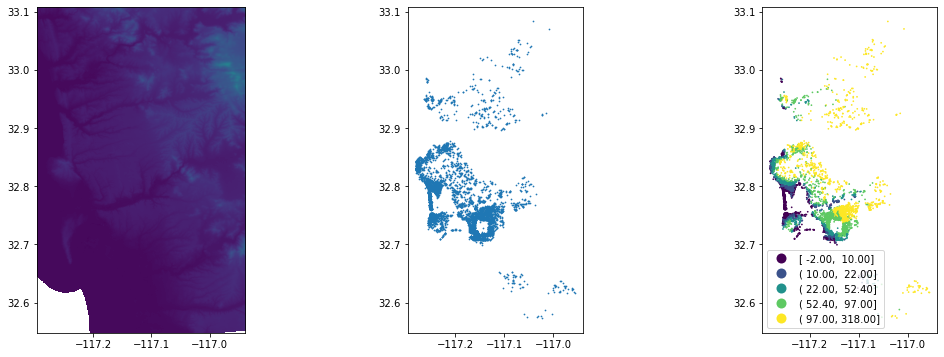

In [23]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

rioshow(dem, ax=axs[0])

airbnbs.plot(ax=axs[1], markersize=0.5)

airbnbs.join(elevation)\
       .plot(column="Elevation",
             scheme="quantiles",
             markersize=0.5,
             legend=True,
             ax=axs[2]
            )

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())

plt.show()

### Point Interpolation using sklearn 

In the previous example, we have transfered information from a surface (stored in a raster layer) to a set of points; in other words, we have gone from surface to points. Sometimes, however, we do not have the luxury of a ready-made surface. Instead, all we have available is a set of points with measurements for the variable of interest that do not match the points we want the information for. In this situation, a solution we can rely on is "spatial interpolation". 

- (streetscore averaging from nearest sites)
- air quality?


### Polygon to point

We now move on to a case where the information we are interested in matching to our set of points is stored for a polygon geography. For example, we would like to know the population density of the neighborhood in which each AirBnb is located. To that, we will download population estimates at the Census tract level, and "transfer" those estimates over to each AirBnb point. Geographically, the only challenge here is finding within which tract every point falls, and the performing what is spatial databases parlance is called a "spatial join", by which we connect the two layers through their spatial connection.

Let us pull down the number of inhabitants from the American Community Survey for tracts in San Diego:

In [31]:
%%time
acs = cenpy.products.ACS()
sd_pop = acs.from_msa("San Diego, CA",
                      level = "tract",
                      variables=['B02001_001E']
                     )

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


CPU times: user 11.7 s, sys: 216 ms, total: 11.9 s
Wall time: 38.7 s


And calculate population density:

In [33]:
sd_pop["density"] = sd_pop["B02001_001E"] / sd_pop.to_crs(epsg=3311).area

Now, to "transfer" density estimates to each AirBnb, we can rely on the spatial join in `geopandas`:

In [39]:
j = geopandas.sjoin(airbnbs, sd_pop.to_crs(airbnbs.crs))

The result is a table with one row per AirBnb and one column for each attribute we originally had for properties, *as well as* those of the tract where the area is located:

In [40]:
j.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6110 entries, 0 to 6068
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   accommodates        6110 non-null   int64   
 1   bathrooms           6110 non-null   float64 
 2   bedrooms            6110 non-null   float64 
 3   beds                6110 non-null   float64 
 4   neighborhood        6110 non-null   object  
 5   pool                6110 non-null   int64   
 6   d2balboa            6110 non-null   float64 
 7   coastal             6110 non-null   int64   
 8   price               6110 non-null   float64 
 9   log_price           6110 non-null   float64 
 10  id                  6110 non-null   int64   
 11  pg_Apartment        6110 non-null   int64   
 12  pg_Condominium      6110 non-null   int64   
 13  pg_House            6110 non-null   int64   
 14  pg_Other            6110 non-null   int64   
 15  pg_Townhouse        6110 non-n

---

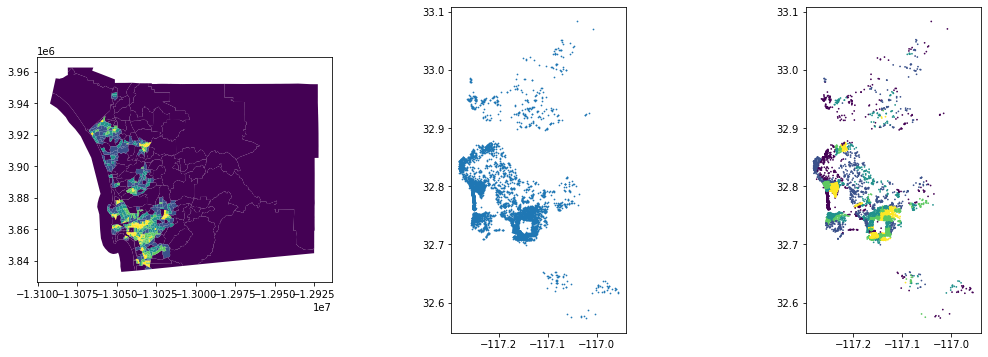

In [43]:
f, axs = plt.subplots(1, 3, figsize=(18, 6))

sd_pop.plot(column="density", scheme="quantiles", ax=axs[0])

airbnbs.plot(ax=axs[1], markersize=0.5)

j.plot(column="density",
       scheme="quantiles",
       markersize=0.5,
       ax=axs[2]
      )

plt.show()

### Area to area interpolation

The final case of map matchin we consider is transfer of information from one polygon/areal geography to a different one. This is a common use-case when an analysis requires data that is provided at different levels of aggregation and different boundary delineations.

There is a large literature around this problem under the umbrella of dasymetric mapping (REF). The conceptual idea is relatively straight-forward: we want to apportion values from one set of polygons to the other based on how much "geography" is shared. In its simplest case, we can do this based on area. In this case, we will assign values from the source geography to the target based on how much they share. Let us illustrate this with an example. We will call the geography for which we have data the "source", and that to which we want to transfer data the "target". If polygon A in the target is made up of 50% of polygon 1 in the source, 30% of polygon 2, and 20% of polygon 3, the estimate for A will be a weighted average between the values in 1, 2, and 3, where the weights are 0.5, 0.3, and 0.2, respectively. Of course, underlying this exercise is the implicit assumption that the values we are interested in are uniformly distributed within each polygon in the source and target. In some cases, this is a valid assumption or, at least, it does not introduce critical errors; in others, this is not acceptable. Dasymetric mapping has proposed a large amount of sophistications that try to come up with more realistic estimates and that can incorporate additional information.

To implement dasymetric mapping in Python, the best option is `tobler`, a package from the PySAL federation designed exactly for this goal. We will show here the simplest case, that of areal interpolation where apportioning is estimated based on area, but the package provides also more sophisticated approaches.

For the example, we need two polygon layers. We will stick with San Diego and use the set of Census Tracts and the [H3 hexagonal grid layer](../data/h3_grid/README.md). Our goal will be to create population estimates for each hexagon.

First, let us pull down population information for the Census tracts in San Diego:

## Feature Engineering using Map Synthesis
*Using spatial relationships within a single dataset to synthesize new features for a model.*
### generalize distanceband/buffer counting into a re-explanation of WX models under different weights
### KNN-engineering, adding features by distances
### distance-banding
### eigenvectors feature engineering
### preclustering points into groups for group-based regressions
### use spatially-constrained clustering to build categorical variables for regression

Ways to "stick" space into models that are not necessarily spatial.

**spatial feature engineering**: synthesizing information using spatial relationships either within the data or across data. 

This is one way of "spatializing" data that is included in models. This is not about fitting *spatial models* that use
> the kohonen quote about spatially-correlated learning in SOMs

it is about figuring out representations of geographical relationships and using them in typical non-spatial models. 



Geographying

Spatializing

*(note: fit the distinction between using spatialized data vs. using spatial models into the regression chapter, ch. 11)*. 

### distance banding counts & distance-to a secondary feature
- osmnx pois
- flicker data

### Point Interpolation using sklearn 
- (streetscore averaging from nearest sites)
- air quality?

### spatial join, but really don't focus too much on the structure/GIS theory of it
- census data 

### tobler? area to area interpolation

- census geographies vs. h3

### raster engineering to vector features

- Elevation: https://blog.mapbox.com/global-elevation-data-6689f1d0ba65
- DEM from USGS? Public domain? https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects
- air quality
- night light - served through nasa, using - contextily

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>.

---

**[To remove eventually]**

But we might want to stuff in a blog post or somewhere else...

In [ ]:
mapbox_access_token = ""
demraw, demext = contextily.bounds2img(*airbnbs.to_crs(epsg=3857).total_bounds, zoom=11,
                                       url='https://api.mapbox.com/v4/mapbox.terrain-rgb/'
                                           '{z}/{x}/{y}.pngraw?access_token='+mapbox_access_token) 

In [ ]:
demraw = demraw.astype(numpy.uint64)

In [ ]:
plt.imshow(demraw)

In [ ]:
h,w,b = demraw.shape

In [ ]:
dem = -1e4 + (demraw[:,:,0]*256**2 + 
              demraw[:,:,1]*256 + 
              demraw[:,:,2])*.1

In [ ]:
plt.imshow(dem)

In [ ]:
airbnbs_webmerc_coords = numpy.column_stack((airbnbs.to_crs(epsg=3857).geometry.x, 
                                             airbnbs.to_crs(epsg=3857).geometry.y))

In [ ]:
dembounds = (demext[0], demext[2], demext[1], demext[3])

In [ ]:
transform = rasterio.transform.from_bounds(*dembounds, w,h)

In [ ]:
with rasterio.MemoryFile() as vfile:
    with vfile.open(driver='GTiff', height=h, width=w, count=1, 
                    dtype=dem.dtype, 
                    crs='epsg:3857', transform=transform) as dem_tmp:
        dem_tmp.write(dem, 1)
        elevation_generator = dem_tmp.sample(airbnbs_webmerc_coords)
        elevation_at_airbnb = numpy.row_stack(list(elevation_generator))

In [ ]:
f,ax = plt.subplots(1,1,figsize=(10,10))
ax = airbnbs.assign(elev = elevation_at_airbnb)\
            .to_crs(epsg=3857).plot('elev', marker='.',ax=ax)
ax.imshow(basemap, extent=basemap_ext)